# MRI Super‑Resolution

In [1]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  Environment & Project Paths                                       ║
# ╚════════════════════════════════════════════════════════════════════╝
from __future__ import annotations

import sys
from pathlib import Path

import torch
import yaml

try:
    from rich import print
except ImportError:
    print = __builtins__["print"]

# ── Device Type ───────────────────────────────────────────────────────
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[bold green]Running on device:[/] {DEVICE}" if "rich" in sys.modules else f"Running on device: {DEVICE}")

# ── Root layout ───────────────────────────────────────────────────────
PROJECT_ROOT: Path = Path.cwd()
SRC_DIR:       Path = PROJECT_ROOT / "src"
CONFIG_DIR:    Path = PROJECT_ROOT / "configs"

sys.path.insert(0, str(SRC_DIR))

# ╔════════════════════════════════════════════════════════════════════╗
# ║  Configuration Loader                                              ║
# ╚════════════════════════════════════════════════════════════════════╝
from utils import Config


def _expect(file: Path) -> Path:
    if not file.exists():
        print(f"[bold red]WARNING - config not found:[/] {file}" if "rich" in sys.modules else f"WARNING - config not found: {file}")
    return file


# ── Load configuration ────────────────────────────────────────────────
BASE_CFG = _expect(CONFIG_DIR / "base_config.yaml")
EXP_CFG  = _expect(CONFIG_DIR / "experiments" / "willnet.yaml")
CFG = Config.load(path=EXP_CFG, base=BASE_CFG)

print(
    f"{'[bold blue]Loaded configuration:[/]' if 'rich' in sys.modules else 'Loaded configuration:'}\n"
    f"{yaml.safe_dump(dict(CFG), sort_keys=False)}"
)

Running on device: cuda

Loaded configuration:
device:
  use_cuda: true
data:
  dir: ./data
  transforms: ./configs/transforms.yaml
  workers: 4
  preview_batch: 1
model:
  name: willnet_se_deep
  in_channels: 1
  out_channels: 1
  mid_channels: 64
  n_blocks: 10
train:
  batch_size: 4
  epochs: 250
  lr: 0.0002
  gamma: 0.6
  patience: 30
  output_dir: checkpoints/willnet_run
  model: willnet_se_deep
  mid_channels: 64
  n_blocks: 10
  checkpoint: null
eval:
  batch_size: 1
  save_visual: true
  output_dir: results/willnet_run
  model: willnet_se_deep
  mid_channels: 64
  n_blocks: 10

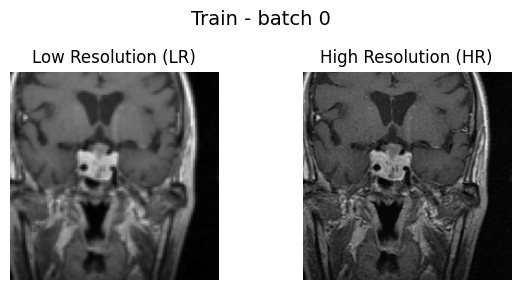

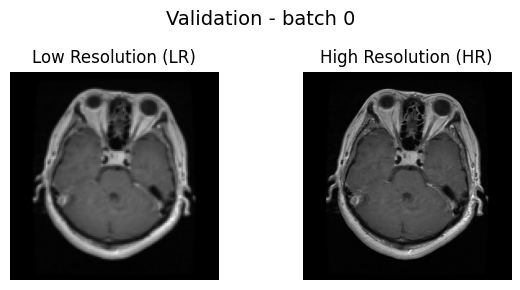

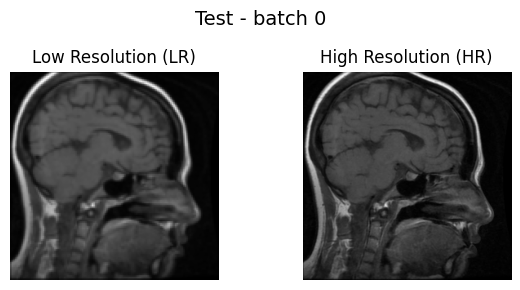

In [ ]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  Data Exploration                                                  ║
# ╚════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt
from utils import create_dataloaders, show_sample

# ── Build loaders ─────────────────────────────────────────────────────
train_loader, val_loader, test_loader = create_dataloaders(
    data_dir         = CFG["data"]["dir"],
    config_path      = CFG["data"]["transforms"],
    loader_to_create = "all",
    batch_size       = CFG["data"].get("preview_batch", 1),
    num_workers      = CFG["data"].get("workers", 4),
)


def preview(loader, title: str, max_batches: int = 1) -> None:
    """Displays batches to verify images."""
    for idx, batch in enumerate(loader):
        show_sample(batch, f"{title} - batch {idx}")
        if idx + 1 >= max_batches:
            break


# ── Quick visual ──────────────────────────────────────────────────────
preview(train_loader, "Train")
preview(val_loader,   "Validation")
preview(test_loader,  "Test")

plt.close("all")

In [ ]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  Model Training                                                    ║
# ╚════════════════════════════════════════════════════════════════════╝
import time
from types import SimpleNamespace

from utils import display_args
from train import Trainer

# ── Build training arguments ──────────────────────────────────────────
train_args = SimpleNamespace(
    **CFG["train"],
    config = str(BASE_CFG)
)
display_args(train_args, title="Training arguments:", indent=2, padding=14)

# ── Run training & time it ────────────────────────────────────────────
start = time.perf_counter()

trainer = Trainer(train_args)
trainer.fit()

elapsed = time.perf_counter() - start
print(f"Training complete in {elapsed/60:.1f} min")


                                Evaluation arguments                                
batch_size    1                                                                     
checkpoint    'checkpoints/willnet_run/willnet_se_deep_best.pth'                    
config        '/home/logan/BME_5710_Project_Team_5/configs/experiments/willnet.yaml'
mid_channels  64                                                                    
model         'willnet_se_deep'                                                     
n_blocks      10                                                                    
output_dir    'results/willnet_run'                                                 
save_visual   True                                                                  
split         'test'

Metric      Bicubic (↑)    TrivialNet (↑)    WillNet (↑)    ΔWill-Bic    ΔWill-Triv
--------  -------------  ----------------  -------------  -----------  ------------
PSNR            30.7101           33.0239        36.5477       5.8375        3.5238
SSIM             0.913             0.9439         0.9684       0.0554        0.0245


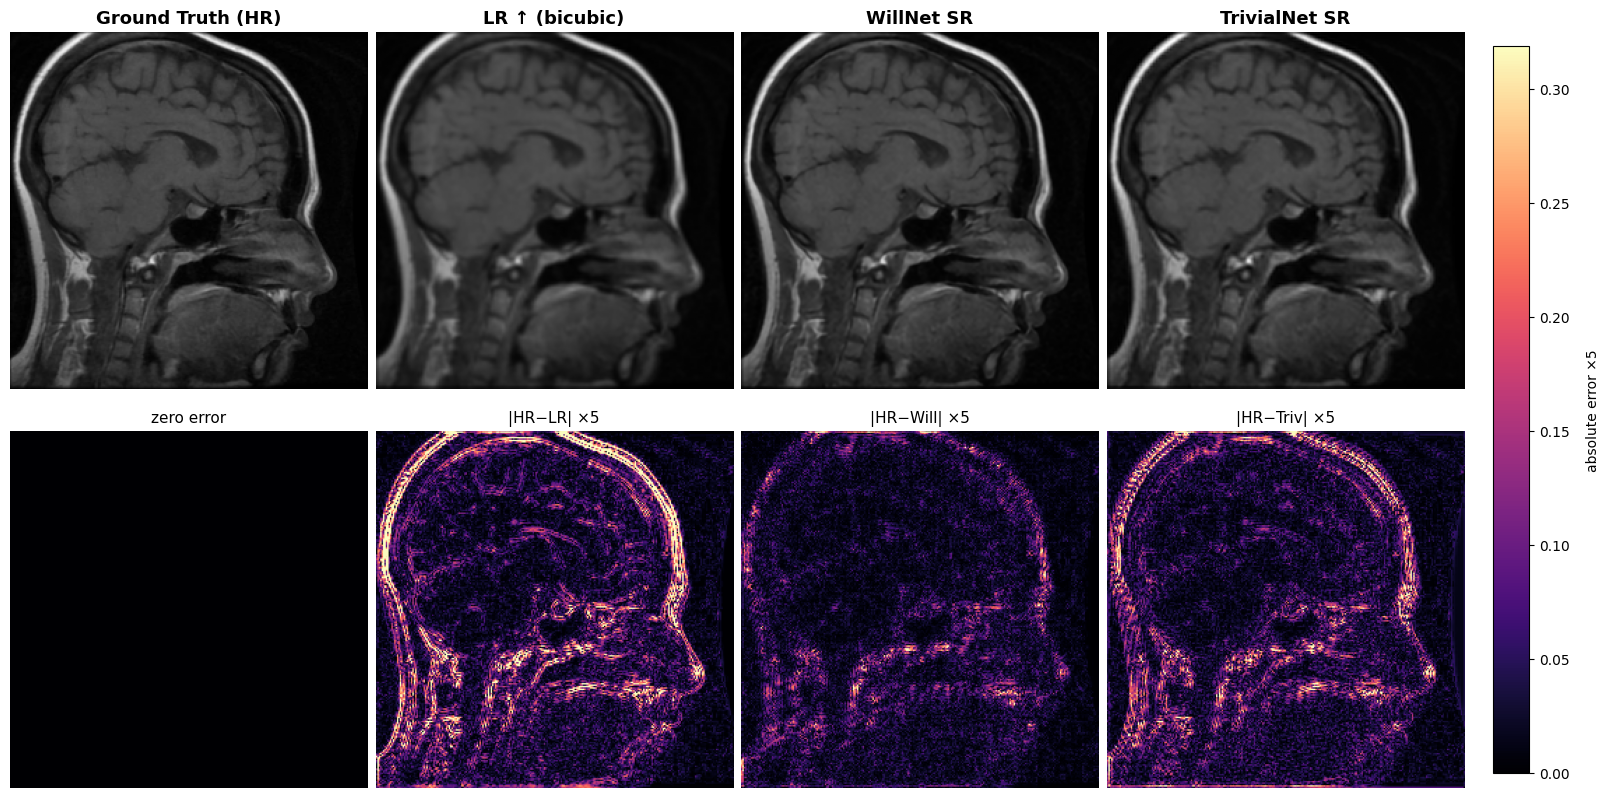

In [ ]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  Model Evaluation                                                  ║
# ╚════════════════════════════════════════════════════════════════════╝
from types import SimpleNamespace

from utils import display_args
from evaluate import Evaluator

# ── Resolve checkpoint path ───────────────────────────────────────────
try:
    ckpt_path: Path = trainer.output_dir / f"{train_args.model}_best.pth"
except NameError:
    ckpt_path = Path(CFG["train"]["output_dir"]) / f"{CFG['train']['model']}_best.pth"

# ── Build evaluation arguments ────────────────────────────────────────
eval_args = SimpleNamespace(
    **CFG["eval"],
    split      = str("test"),
    config     = str(EXP_CFG),
    checkpoint = str(ckpt_path),
)
display_args(eval_args, title="Evaluation arguments", indent=2, padding=14)

# ── Run evaluation ────────────────────────────────────────────────────
evaluator = Evaluator(eval_args)
metrics: dict = evaluator.run()